# Clinical trial design optimization 

## Loading dependencies

In [1]:
# Cookbook specifics imports
import jinko_helpers as jinko
import io
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as colors
import scipy.stats as st
from sklearn.neighbors import KNeighborsRegressor, KDTree
from sklearn.preprocessing import StandardScaler
import zipfile
import textwrap

## Defining general parameters

In [2]:
# Jinko trial short ID, URL pattern is "https://jinko.ai/{trial_sid}"
trial_sid = "tr-HLRF-b0zW"
# Outcome ID
outcome_name = "tumorBurdenChangeFromBaseline.tend"
# control and treated arm IDs
control_arm_id = "sc-1-10"
treated_arm_id = "iv-1-10"

"""
Sample size parameters
"""
alpha = 0.05
beta = 0.2

""" 
Features sorted by descending order of importance (as per tornado or Random Forest analysis for instance)
See "sensitivity_analysis.ipynb"
"""
all_features = [
    "initialTumorBurden.tmin",
    "ec50Drug.tmin",
    "Blood.tmin",
    "Tissue.tmin",
    "kClearanceDrug.tmin",
]

""" Minimal size of the filtered responder vpop
(number of times the required sample size should be included in the responder vp in terms of nb of patients)
Will be evaluated for each set of eligibility criteria
"""
min_resp_vp_size = 10

"""
Objective function weights
"""
# weight of gross efficacy
efficacy_wt = 1
# weight of standard deviation of gross efficacy
efficacy_sd_wt = 2

"""
Boostrapping parameters
"""
## Number of bootstraps for gross efficacy dispersion estimation
num_bootstraps = 50
## Seed for all random processes
cookbook_seed = 2025

## Defining functions
### Sample size computation

In [3]:
# Definition of sample size computation formulas
## Sample size for two independent samples, continuous outcome
def sample_size_continuous_outcome(alpha, beta, diff_btw_groups, sd_outcome, dropout=0):
    z_alpha = st.norm.ppf(1 - (alpha / 2))
    z_beta = st.norm.ppf(1 - beta)

    return (2 * ((z_alpha + z_beta) / (abs(diff_btw_groups) / sd_outcome)) ** 2) / (
        1 - dropout
    )

### Objective function

In [4]:
# Objective function to be maximized
def objective_function(
    efficacy,
    efficacy_sd,
):
    return (efficacy * efficacy_wt - efficacy_sd * efficacy_sd_wt) / (
        efficacy_wt + efficacy_sd_wt
    )

## Loading trial results from Jinko

In [ ]:
jinko.initialize()

# Convert short id to core item id
trial_core_item_id = jinko.get_core_item_id(trial_sid, 1)


# Choose a specific revision. By default we return the last version
revision = None
# Choose a specific label. By default we return the last version
label = "cookbook"
response = jinko.get_project_item(sid=trial_sid, revision=revision, label=label)
trial_core_item_id, trial_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)

# Uncomment the following to get the latest completed version instead
# # List all trial versions
# # https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--status/get
# versions = jinko.make_request(
#     f'/core/v2/trial_manager/trial/{trial_core_item_id["id"]}/status'
# ).json()
# # Get the latest completed version
# try:
#     latest_completed_version = next(
#         (item for item in versions if item["status"] == "completed"), None
#     )
#     if latest_completed_version is None:
#         raise Exception("No completed trial version found")
#     else:
#         simulation_id = latest_completed_version["simulationId"]
#         trial_core_item_id = simulation_id["coreItemId"]
#         trial_snapshot_id = simulation_id["snapshotId"]
# except Exception as e:
#     print(f"Error processing trial versions: {e}")
#     raise

# https://doc.jinko.ai/api/#/paths/core-v2-result_manager-scalars_summary/post
response = jinko.make_request(
    path="/core/v2/result_manager/scalars_summary",
    method="POST",
    json={
        "select": all_features + [outcome_name],
        "trialId": {"coreItemId": trial_core_item_id, "snapshotId": trial_snapshot_id},
    },
)
archive = zipfile.ZipFile(io.BytesIO(response.content))
filename = archive.namelist()[0]

csv_scalars = archive.read(filename).decode("utf-8")

scalars_dtf = pd.read_csv(io.StringIO(csv_scalars))
print("Number of rows in the initial table:", len(scalars_dtf))

Authentication successful


Number of rows in the initial table: 89934


In [6]:
# assembling the dataframes of interest
cross_arm_scalars = scalars_dtf.loc[scalars_dtf["armId"] == "crossArms"].pivot(
    index="patientId", columns="scalarId", values="value"
)
control_arm_scalars = scalars_dtf.loc[scalars_dtf["armId"] == control_arm_id].pivot(
    index="patientId", columns="scalarId", values="value"
)
treated_arm_scalars = scalars_dtf.loc[scalars_dtf["armId"] == treated_arm_id].pivot(
    index="patientId", columns="scalarId", values="value"
)
control_arm_scalars = pd.merge(
    left=cross_arm_scalars, right=control_arm_scalars, how="left", on="patientId"
)
treated_arm_scalars = pd.merge(
    left=cross_arm_scalars, right=treated_arm_scalars, how="left", on="patientId"
)

print(f"cross_arm_scalars table has {len(cross_arm_scalars)} rows")
print(f"control_arm_scalars table has {len(control_arm_scalars)} rows")
print(f"treated_arm_scalars table has {len(treated_arm_scalars)} rows")

cross_arm_scalars table has 10000 rows
control_arm_scalars table has 10000 rows
treated_arm_scalars table has 10000 rows


## Trial net efficacy and sample size

In [7]:
mean_control = control_arm_scalars[outcome_name].mean()
mean_treated = treated_arm_scalars[outcome_name].mean()
initial_net_efficacy = mean_control - mean_treated

std_control = control_arm_scalars[outcome_name].std()
std_treated = treated_arm_scalars[outcome_name].std()

print(
    f"This trial has a net efficacy of {initial_net_efficacy:.3g} (standard deviation of outcome in control group = {std_control:.2g})"
)
sample_size = math.ceil(
    sample_size_continuous_outcome(alpha, beta, initial_net_efficacy, std_control)
)
print(
    f"With beta = {beta}, this means a sample size of {sample_size} patients per group"
)

This trial has a net efficacy of 2.23 (standard deviation of outcome in control group = 3.3)
With beta = 0.2, this means a sample size of 35 patients per group


## Plotting score proxy

While the actual score function takes the average and standard deviation of the bootstrapped gross efficacy, this is 
rather costly to evaluate (because of the bootstraps).
Here, we leverage the fact that:

  1. the mean of the gross efficacy can be approximated by the mean of the absolute benefit 
  2. the variance of the gross efficacy can be approximated by '(var(outcome_control) + var(outcome_treated)) / sample_size'
to compute a so-called "score proxy"


Using a nearest-neighbor regression with "number of neighbors = sample_size * min_resp_vp_size", the Chebyshev norm and uniform weighting, 
we can compute a score proxy for each trial patient which approximates what the actual score sould be for 
a sub-population of size sample_size centered around each patient

Min score proxy = 0.203, max score proxy = 0.905


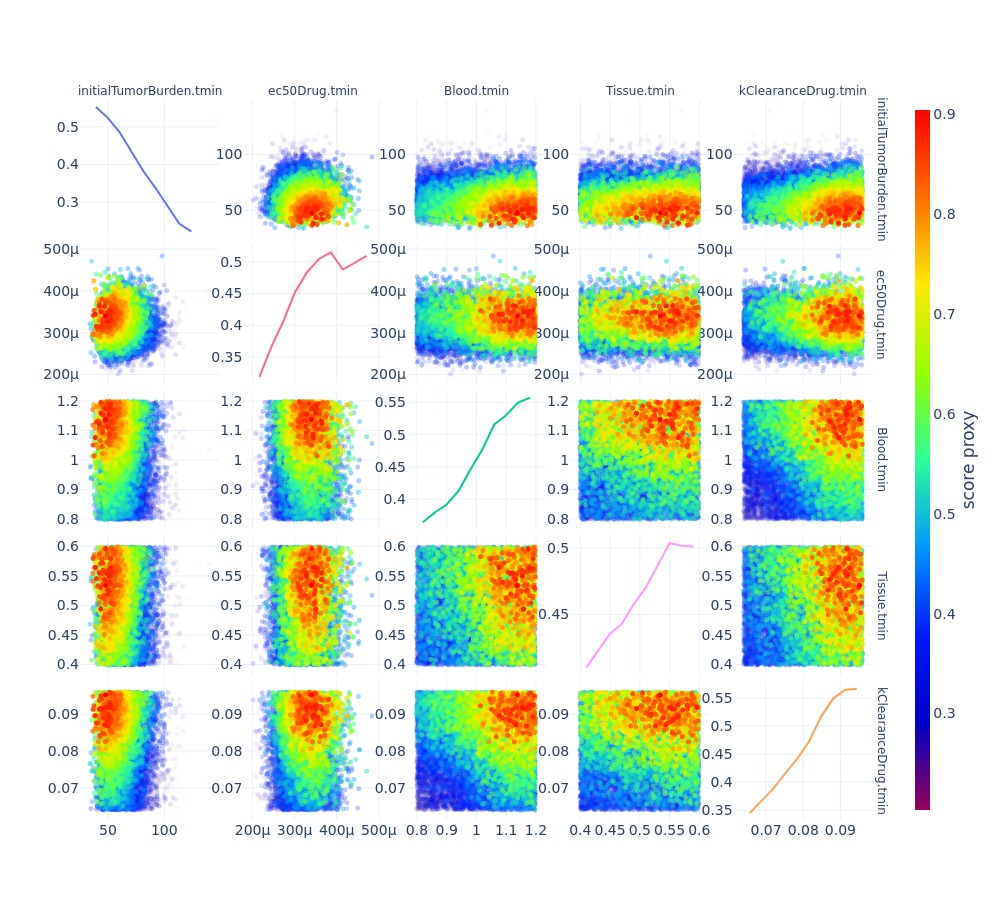

In [ ]:
efficacy_df = pd.merge(
    control_arm_scalars, treated_arm_scalars[outcome_name], how="inner", on="patientId"
)
efficacy_df = efficacy_df.dropna()

neigh_regressor = KNeighborsRegressor(
    n_neighbors=sample_size * min_resp_vp_size, weights="uniform", metric="chebyshev"
)
X_unscaled = efficacy_df[all_features].to_numpy()
feature_scaler = StandardScaler().fit(X_unscaled)
X = feature_scaler.transform(X_unscaled)
for z in ["x", "y"]:
    neigh_regressor.fit(
        X,
        efficacy_df[f"{outcome_name}_{z}"].to_numpy(),
    )
    efficacy_df[f"mu_{outcome_name}_{z}"] = neigh_regressor.predict(X)

    neigh_regressor.fit(
        X,
        (efficacy_df[f"{outcome_name}_{z}"].to_numpy()) ** 2,
    )
    efficacy_df[f"mu_{outcome_name}_{z}2"] = neigh_regressor.predict(X)
    efficacy_df[f"var_{outcome_name}_{z}"] = (
        efficacy_df[f"mu_{outcome_name}_{z}2"]
        - efficacy_df[f"mu_{outcome_name}_{z}"] ** 2
    )

# score proxy where the mean of gross efficacy is approximated using the mean of absolute benefit
# and the variance of gross efficacy is approximated as 'var(control) + var(treated) / sample_size'
efficacy_df["score_proxy"] = objective_function(
    efficacy_df[f"mu_{outcome_name}_x"] - efficacy_df[f"mu_{outcome_name}_y"],
    np.sqrt(efficacy_df[f"var_{outcome_name}_x"] + efficacy_df[f"var_{outcome_name}_y"])
    / np.sqrt(sample_size),
)
min_score, max_score = (
    efficacy_df["score_proxy"].min(),
    efficacy_df["score_proxy"].max(),
)
print(f"Min score proxy = {min_score:.3g}, max score proxy = {max_score:.3g}")

efficacy_df = efficacy_df.sort_values(by="score_proxy")
num_features = len(all_features)
features_wrapped = ["<br>".join(textwrap.wrap(t, width=30)) for t in all_features]
fig = make_subplots(
    num_features,
    num_features,
    shared_xaxes=True,
    shared_yaxes=False,
    horizontal_spacing=0.03,
    vertical_spacing=0.01,
    column_titles=features_wrapped,
    row_titles=features_wrapped,
)

for i in range(num_features):  # iterating over rows
    for j in range(num_features):  # iterating over columns
        if i == j:  # do not plot anything on the diagonal
            x = efficacy_df[all_features[i]]
            nx = 10
            xs = np.linspace(x.min(), x.max(), nx + 1)
            y = []
            for k in range(nx):
                eff_k = efficacy_df[
                    (efficacy_df[all_features[i]] >= xs[k])
                    & (efficacy_df[all_features[i]] < xs[k + 1])
                ]["score_proxy"]
                y.append(eff_k.mean())
            fig.add_trace(
                go.Scatter(x=xs[:-1] + 0.5 * (xs[1] - xs[0]), y=y, mode="lines"),
                row=i + 1,
                col=j + 1,
            )
        else:
            fig.add_trace(
                go.Scattergl(
                    x=efficacy_df[all_features[j]],
                    y=efficacy_df[all_features[i]],
                    mode="markers",
                    marker=dict(
                        size=5,
                        color=efficacy_df["score_proxy"],
                        opacity=(efficacy_df["score_proxy"] - min_score)
                        / (max_score - min_score),
                        coloraxis="coloraxis1",
                    ),
                    hoverinfo="none",
                ),
                row=i + 1,
                col=j + 1,
            )
fig.update_annotations(font_size=12)
fig.update_coloraxes(
    colorbar_title="score proxy",
    cmin=min_score,
    cmax=max_score,
    colorscale="rainbow",
    colorbar_thickness=15,
    colorbar_title_side="right",
)
fig.update_layout(
    font=dict(size=14),
    showlegend=False,
    width=1000,
    height=900,
    template="plotly_white",
)
fig.show(renderer="jpeg")

## Selecting features

In [9]:
num_features = min(5, len(all_features))
features = all_features[:num_features]
print(f"Selected features: {features}")


def to_row(x_vec, columns):
    return {columns[i]: x for i, x in enumerate(x_vec)}


def lower_bound(d):
    return f"{d}_lower_bound"


def width(d):
    return f"{d}_width"


feature_bounds = {
    d: (cross_arm_scalars.min(axis=0)[d], cross_arm_scalars.max(axis=0)[d])
    for d in features
}
column_bounds = {}
for d in features:
    (d_min, d_max) = feature_bounds[d]
    column_bounds[lower_bound(d)] = (d_min, d_max - 0.1 * (d_max - d_min))
    column_bounds[width(d)] = (0.1 * (d_max - d_min), d_max - d_min)

dim = len(column_bounds)
column_keys = list(column_bounds.keys())


def format_eligibility_criteria(criteria):
    s = ""
    for f in features:
        s += f"\n {criteria[lower_bound(f)]:.3g} <= {f} <= {criteria[lower_bound(f)] + criteria[width(f)]:.3g}"
    return s

Selected features: ['initialTumorBurden.tmin', 'ec50Drug.tmin', 'Blood.tmin', 'Tissue.tmin', 'kClearanceDrug.tmin']


## Efficacy tooling

In [10]:
def filter_conditions(row):
    conditions = [
        (cross_arm_scalars[d] >= row[lower_bound(d)])
        & (cross_arm_scalars[d] <= row[lower_bound(d)] + row[width(d)])
        for d in features
    ]
    return np.logical_and.reduce(conditions)


def group_size(row):
    return len(cross_arm_scalars[filter_conditions(row)])


def filter(row):
    if group_size(row) < sample_size * min_resp_vp_size:
        return False
    else:
        return True


def score(row, seed=cookbook_seed, n_boot=num_bootstraps, verbose=False):
    mean_efficacy, sd_efficacy = gross_efficacy(row, seed=seed, n_boot=n_boot)
    if verbose:
        print(f"mean, std of gross efficacy = {mean_efficacy:.3g}, {sd_efficacy:.2g}")
    if mean_efficacy and sd_efficacy:
        return objective_function(
            efficacy=mean_efficacy,
            efficacy_sd=sd_efficacy,
        )
    else:
        return None


def gross_efficacy(row, seed=cookbook_seed, n_boot=num_bootstraps):
    # A reproducible random generator whose seed depends on the top-level cookbook seed AND the evaluated design row
    seeds = [seed, abs(hash(frozenset(row.items())))]
    # Creating the corresponding control and treated filtered dataset
    control_filtered = control_arm_scalars[filter_conditions(row)][outcome_name]
    treated_filtered = treated_arm_scalars[filter_conditions(row)][outcome_name]
    if len(control_filtered) < sample_size * min_resp_vp_size:
        return None, None
    else:
        return bootstrapped_gross_efficacy(
            control_filtered, treated_filtered, seeds, n_boot=n_boot
        )


def bootstrapped_gross_efficacy(control_filtered, treated_filtered, seeds, n_boot):
    # A reproducible random generator whose seed depends on the top-level cookbook seed AND the evaluated design row
    rng = np.random.default_rng(seeds)
    bootstrap_gross_efficacies = []
    all_indices = np.arange(len(control_filtered))
    for _ in range(n_boot):
        # pick 2 * sample_size indices at random from the full dataset
        shuffled_indices = rng.choice(all_indices, size=2 * sample_size, replace=False)
        # first sample_size indices for the control sub-group
        ctrl_mean = control_filtered.iloc[shuffled_indices[:sample_size]].mean()
        # next sample_size indices for the treated sub-group
        trtd_mean = treated_filtered.iloc[
            shuffled_indices[sample_size : 2 * sample_size]
        ].mean()
        bootstrap_gross_efficacies.append(ctrl_mean - trtd_mean)

    return np.mean(bootstrap_gross_efficacies), np.std(
        bootstrap_gross_efficacies, ddof=1
    )


def score_proxy(row):
    control_filtered = control_arm_scalars[filter_conditions(row)][outcome_name]
    treated_filtered = treated_arm_scalars[filter_conditions(row)][outcome_name]

    if len(control_filtered) < sample_size * min_resp_vp_size:
        return None

    mean_efficacy = control_filtered.mean() - treated_filtered.mean()
    var_efficacy = (control_filtered.var() + treated_filtered.var()) / sample_size

    return objective_function(
        efficacy=mean_efficacy,
        efficacy_sd=np.sqrt(var_efficacy),
    )


def net_efficacy(row):
    control_filtered = control_arm_scalars[filter_conditions(row)]
    treated_filtered = treated_arm_scalars[filter_conditions(row)]
    efficacy_df = pd.merge(
        control_filtered, treated_filtered[outcome_name], how="inner", on="patientId"
    )
    efficacy_df["net_efficacy"] = (
        efficacy_df[f"{outcome_name}_x"] - efficacy_df[f"{outcome_name}_y"]
    )
    mean_efficacy, std_efficacy = (
        efficacy_df["net_efficacy"].mean(),
        efficacy_df["net_efficacy"].std(),
    )
    return (mean_efficacy, std_efficacy)

## Eligibility criteria optimization using score proxy

In [11]:
imax = efficacy_df["score_proxy"].argmax()
print(
    f"Best score proxy = {efficacy_df.iloc[imax]["score_proxy"]:.3g}, index of patient with best score proxy: {imax}"
)
display(efficacy_df.iloc[imax][features])
x0_unscaled = efficacy_df.iloc[imax][features].to_numpy()

X_unscaled = efficacy_df[features].to_numpy()
feature_scaler = StandardScaler().fit(X_unscaled)
X = feature_scaler.transform(X_unscaled)
neigh_regressor.fit(X, efficacy_df[f"{outcome_name}_x"].to_numpy())

x0_scaled = feature_scaler.transform(np.reshape(x0_unscaled, (1, x0_unscaled.size)))
distances, indices = neigh_regressor.kneighbors(
    x0_scaled, n_neighbors=sample_size * min_resp_vp_size
)

neighbors_features_scaled = X[indices[0, :], :]
neighbors_features_unscaled = feature_scaler.inverse_transform(
    neighbors_features_scaled
)
score_proxy_criteria = {}
for i, f in enumerate(features):
    min_f, max_f = np.amin(neighbors_features_unscaled[:, i]), np.amax(
        neighbors_features_unscaled[:, i]
    )
    score_proxy_criteria[lower_bound(f)] = min_f
    score_proxy_criteria[width(f)] = max_f - min_f
print(format_eligibility_criteria(score_proxy_criteria))

n_boot = 100
mean_ge, sd_ge = gross_efficacy(score_proxy_criteria, n_boot=n_boot)
actual_score = objective_function(mean_ge, sd_ge)
print(f"\nMean of gross efficacy (with {n_boot} bootstraps) = {mean_ge:.3g}")
print(f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_ge:.2g}")
print(f"Actual score = {actual_score:.3g}")

Best score proxy = 0.905, index of patient with best score proxy: 9969


initialTumorBurden.tmin    48.014537
ec50Drug.tmin               0.000341
Blood.tmin                  1.139190
Tissue.tmin                 0.534931
kClearanceDrug.tmin         0.095226
Name: 2663e261-9a86-d04f-3b82-2b661ef71539, dtype: float64


 36.9 <= initialTumorBurden.tmin <= 61.7
 0.000299 <= ec50Drug.tmin <= 0.000383
 1.01 <= Blood.tmin <= 1.2
 0.469 <= Tissue.tmin <= 0.6
 0.0848 <= kClearanceDrug.tmin <= 0.096

Mean of gross efficacy (with 100 bootstraps) = 3.85
Standard deviation of gross efficacy (with 100 bootstraps) = 0.63
Actual score = 0.861


## Eligibility criteria optimization using Sobol sequence grid search + MC fine tuning

### Sobol sequence grid search

In [12]:
sampler = st.qmc.Sobol(dim, scramble=False)
m = 13
print(f"Full design size = {2**m}")
scaled_samples = sampler.random_base2(m)  # generates 2**m points


def unscale(x):
    return st.qmc.scale(
        x,
        [column_bounds[c][0] for c in column_keys],
        [column_bounds[c][1] for c in column_keys],
    )


def scale(x):
    return st.qmc.scale(
        x,
        [column_bounds[c][0] for c in column_keys],
        [column_bounds[c][1] for c in column_keys],
        reverse=True,
    )


samples = unscale(scaled_samples)

filtered_indices = []
for i, x in enumerate(samples):
    row = to_row(x, columns=column_keys)
    if filter(row):
        filtered_indices.append(i)
print(f"Number of admissible points = {len(filtered_indices)} / {samples.shape[0]}")
filtered_samples = samples[filtered_indices, :]

y = [score_proxy(to_row(x, columns=column_keys)) for x in filtered_samples]
design_i_max, design_y_max = np.argmax(y), np.amax(y)
exhaustive_best_criteria = to_row(filtered_samples[design_i_max], columns=column_keys)
print(
    "Best eligibility criteria:\n"
    + format_eligibility_criteria(exhaustive_best_criteria)
)
print(f"\nBest score proxy = {design_y_max:.3g}")

n_boot = 100
mean_ge, sd_ge = gross_efficacy(exhaustive_best_criteria, n_boot=n_boot)
actual_score = objective_function(mean_ge, sd_ge)
print(f"Mean of gross efficacy (with {n_boot} bootstraps) = {mean_ge:.3g}")
print(f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_ge:.2g}")
print(f"Actual score = {actual_score:.3g}")

Full design size = 8192
Number of admissible points = 479 / 8192
Best eligibility criteria:

 39.3 <= initialTumorBurden.tmin <= 61.4
 0.000313 <= ec50Drug.tmin <= 0.000541
 1.05 <= Blood.tmin <= 1.33
 0.401 <= Tissue.tmin <= 0.574
 0.0828 <= kClearanceDrug.tmin <= 0.107

Best score proxy = 0.889
Mean of gross efficacy (with 100 bootstraps) = 3.87
Standard deviation of gross efficacy (with 100 bootstraps) = 0.66
Actual score = 0.849


### MC fine-tuning

After having found the best point in the Sobol design of experiment, let's search for an even better set of
eligibility criteria around said point

In [13]:
scaled_x = scale(filtered_samples)
tree = KDTree(scaled_x)
k = 10
x0 = scaled_x[design_i_max, :]
distances, indices = tree.query(np.reshape(x0, (1, x0.size)), k=k)
# distance to kth nearest neighbor
radius = distances[0, k - 1]

rng = np.random.default_rng([cookbook_seed])
num_mc = 10000
# the average squared distance from the mean in a multivariate normal distribution is tr(Σ)
# so by choosing a standard deviation of sigma = radius / sqrt(dim), our sampled points will lie in average
# at a distance of radius from x0
scaled_mc = rng.normal(loc=x0, scale=radius / np.sqrt(dim), size=(num_mc, dim))
scaled_mc[scaled_mc < 0] = 0
scaled_mc[scaled_mc > 1] = 1
X_mc = unscale(scaled_mc)
filtered_indices = []
for i, x in enumerate(X_mc):
    row = to_row(x, columns=column_keys)
    if filter(row):
        filtered_indices.append(i)

print(
    f"MC fine-tuning, number of admissible points = {len(filtered_indices)} / {X_mc.shape[0]} "
)
X_mc_filtered = X_mc[filtered_indices, :]
y_mc = np.array([score_proxy(to_row(x, columns=column_keys)) for x in X_mc_filtered])
mc_i_max = np.argmax(y_mc)
mc_best_score = y_mc[mc_i_max]
mc_best_criteria = to_row(X_mc_filtered[mc_i_max], columns=column_keys)
print("Best eligibility criteria:\n" + format_eligibility_criteria(mc_best_criteria))
print(f"\nBest score proxy = {mc_best_score:.3g}")

n_boot = 100
mean_ge, sd_ge = gross_efficacy(mc_best_criteria, n_boot=n_boot)
actual_score = objective_function(mean_ge, sd_ge)
print(f"Mean of gross efficacy (with {n_boot} bootstraps) = {mean_ge:.3g}")
print(f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_ge:.2g}")
print(f"Actual score = {actual_score:.3g}")

MC fine-tuning, number of admissible points = 2827 / 10000 
Best eligibility criteria:

 38.5 <= initialTumorBurden.tmin <= 64.9
 0.000283 <= ec50Drug.tmin <= 0.000531
 1.05 <= Blood.tmin <= 1.38
 0.455 <= Tissue.tmin <= 0.655
 0.0876 <= kClearanceDrug.tmin <= 0.11

Best score proxy = 0.896
Mean of gross efficacy (with 100 bootstraps) = 3.97
Standard deviation of gross efficacy (with 100 bootstraps) = 0.64
Actual score = 0.894


## Potential gains

In [ ]:
def print_report(criteria, n_boot):
    num_responding = group_size(criteria)
    print(f"  Number of unique best responding patients: {num_responding}")
    mean_gross_efficacy, sd_gross_efficacy = gross_efficacy(criteria, n_boot=n_boot)
    print(
        f"  Mean of gross efficacy (with {n_boot} bootstraps) = {mean_gross_efficacy:.3g}"
    )
    print(
        f"  Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_gross_efficacy:.2g}"
    )
    control_filtered = control_arm_scalars[filter_conditions(criteria)][outcome_name]
    treated_filtered = treated_arm_scalars[filter_conditions(criteria)][outcome_name]
    best_responders_net_efficacy = control_filtered.mean() - treated_filtered.mean()
    print(
        f"  Net efficacy in the population of best responders = {best_responders_net_efficacy:.3g}"
    )
    print(
        f"    --> gain in net efficacy = {best_responders_net_efficacy - initial_net_efficacy:.3g} (+{(best_responders_net_efficacy - initial_net_efficacy)/initial_net_efficacy:.0%})"
    )
    control_outcome_std = control_filtered.std()
    best_sample_size = math.ceil(
        sample_size_continuous_outcome(
            alpha, beta, best_responders_net_efficacy, control_outcome_std
        )
    )
    print(
        f"  Required sample size in population of best responders = {best_sample_size}"
    )
    print(
        f"    --> gain in required sample size = {sample_size - best_sample_size} (-{(sample_size - best_sample_size)/sample_size:.0%})"
    )


n_boot = 50
print(f"Net efficacy in initial population = {initial_net_efficacy:.3g}")
mean_gross_efficacy, sd_gross_efficacy = bootstrapped_gross_efficacy(
    control_arm_scalars[outcome_name],
    treated_arm_scalars[outcome_name],
    seeds=[0],
    n_boot=n_boot,
)
print(f"Mean of gross efficacy (with {n_boot} bootstraps) = {mean_gross_efficacy:.3g}")
print(
    f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_gross_efficacy:.2g}"
)
print(f"Required sample size in initial population = {sample_size}")


print("\nEligibility criteria using Sobol design exhaustive search + MC fine-tuning:")
print_report(mc_best_criteria, n_boot=n_boot)

print("\nEligibility criteria using score proxy:")
print_report(score_proxy_criteria, n_boot=n_boot)

Net efficacy in initial population = 2.23
Mean of gross efficacy (with 50 bootstraps) = 2.32
Standard deviation of gross efficacy (with 50 bootstraps) = 0.68
Required sample size in initial population = 35

Eligibility criteria using Sobol design exhaustive search + MC fine-tuning:
  Number of unique best responding patients: 359
  Mean of gross efficacy (with 50 bootstraps) = 4.04
  Standard deviation of gross efficacy (with 50 bootstraps) = 0.59
  Net efficacy in the population of best responders = 3.91
    --> gain in net efficacy = 1.68 (+75%)
  Required sample size in population of best responders = 9
    --> gain in required sample size = 26 (-74%)

Eligibility criteria using score proxy:
  Number of unique best responding patients: 350
  Mean of gross efficacy (with 50 bootstraps) = 3.96
  Standard deviation of gross efficacy (with 50 bootstraps) = 0.54
  Net efficacy in the population of best responders = 3.92
    --> gain in net efficacy = 1.69 (+76%)
  Required sample size in

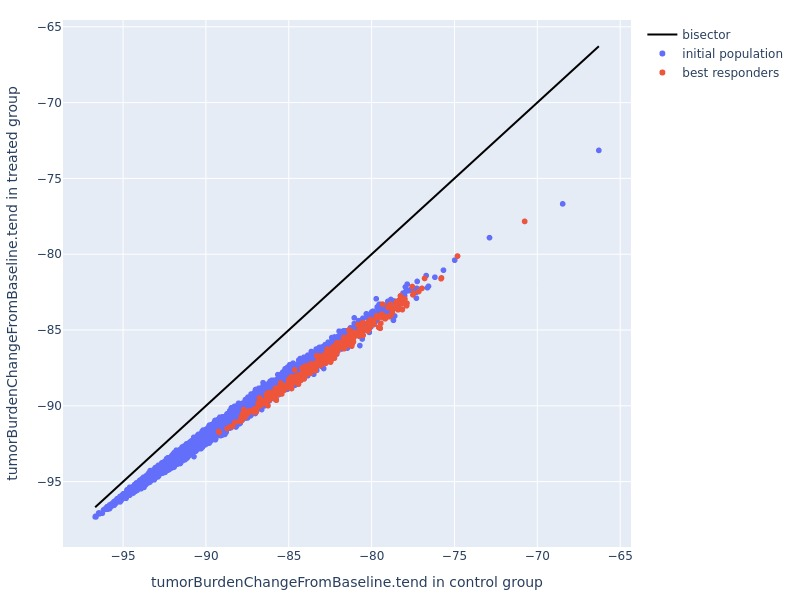

In [78]:
fig = go.Figure()
outcome = control_arm_scalars[outcome_name]
bisector = np.array([outcome.min(), outcome.max()])
fig.add_trace(
    go.Scatter(
        x=bisector, y=bisector, mode="lines", line_color="black", name="bisector"
    )
)
fig.add_trace(
    go.Scattergl(
        x=control_arm_scalars[outcome_name],
        y=treated_arm_scalars[outcome_name],
        mode="markers",
        marker=dict(
            color=colors.qualitative.Plotly[0],
        ),
        name="initial population",
        hoverinfo="none",
    )
)
fig.add_trace(
    go.Scattergl(
        x=control_arm_scalars[filter_conditions(mc_best_criteria)][outcome_name],
        y=treated_arm_scalars[filter_conditions(mc_best_criteria)][outcome_name],
        mode="markers",
        marker=dict(
            color=colors.qualitative.Plotly[1],
        ),
        name="best responders",
        hoverinfo="none",
    )
)
fig.update_xaxes(title_text=f"{outcome_name} in control group")
fig.update_yaxes(title_text=f"{outcome_name} in treated group")
fig.update_annotations(font_size=12)
fig.update_layout(
    showlegend=True,
    width=800,
    height=600,
    margin=dict(l=50, r=20, t=20, b=20),
)
fig.show(renderer="jpeg")